In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from datasets import SegmentationDataset
from tqdm import tqdm












import torch
from torch import nn

from segnet import SegNet


In [10]:
transform = A.Compose([
    A.Resize(width=128, height=128),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
])
path_to_dataset='/home/aggr/mikhail_u/mice_holes_dataset'
names_list = sorted([f[:-4] for f in os.listdir(os.path.join(path_to_dataset, 'images')) if f.endswith('.jpg')])
train_dataset = SegmentationDataset(path_to_dataset=path_to_dataset, instance_names_list=names_list, transforms=transform)

for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]

100%|██████████| 247/247 [00:05<00:00, 44.10it/s]


In [1]:
from trainer import SegmentationTrainer
from train import SegmentationWrapper, ConfusionMatrix, ConfusionIoU, MeanConfuaionIou, ConfusionAccuracy
from datasets import SegmentationDataset
import torch
import random
import os
from segmentation_autoencoder import SegmentationAutoencoder
from PIL import Image

import cv2
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

/home/aggr/anaconda3/envs/segmentation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
stat_df = pd.read_csv(r'I:\saratov_2020\dataset_256_256\overall_pixel_stats.csv').drop(['Название изображения'], axis=1)*np.prod((256, 256))
(stat_df.sum(axis=0)).to_numpy()

array([6.38256574e+08, 3.31058219e+10, 1.96752698e+10, 3.11351272e+09,
       1.93609911e+08, 1.25026059e+08])

In [4]:
path_to_model = r'saving_dir/15.06.2022, 18-56-41 (segmentation_autoencoder)/segmentation_autoencoder_current_ep-199.pt'
model = torch.load(path_to_model)#.model
model

In [2]:
path_to_chkpt = r'saving_dir/21.06.2022, 21-32-18 (unet1)/unet1_current_ep-999.pt'
trainer = torch.load(path_to_chkpt)

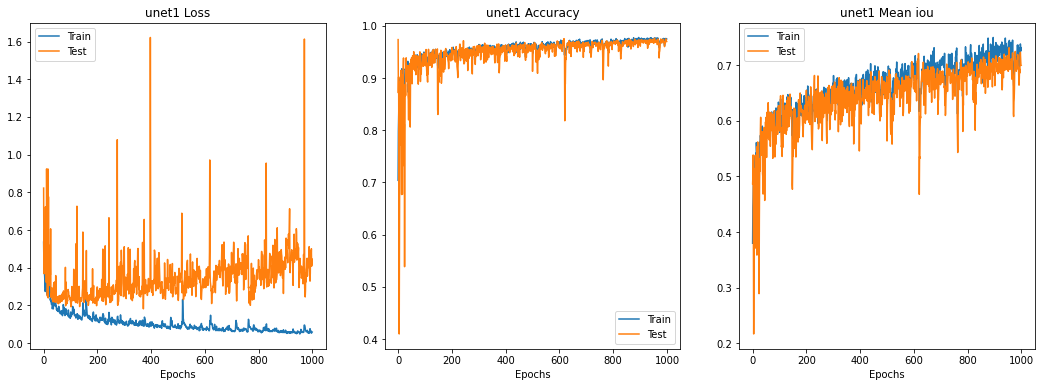

In [3]:
trainer.plot_train_process_results(['loss', 'accuracy', 'mean IoU'], save_plot=True)

100%|██████████| 8/8 [00:34<00:00,  4.29s/it]


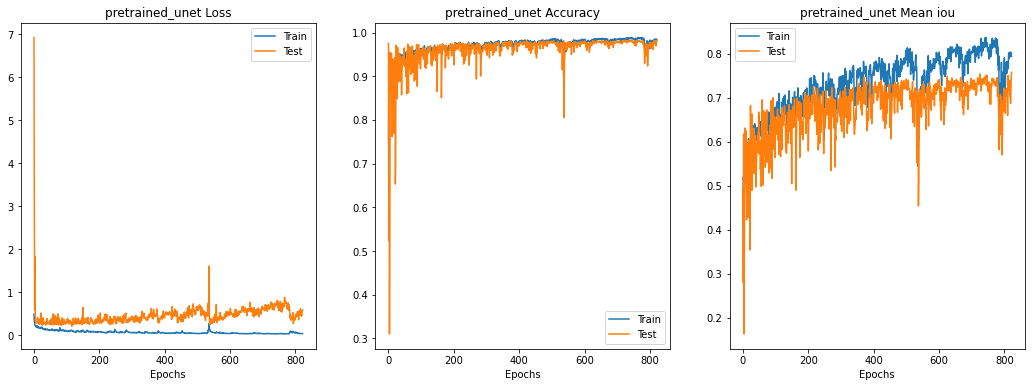

In [17]:
# draw segmrented figures
def to_uint8(img):
    return np.uint8(img*255)

path_to_chkpt = r'saving_dir/23.06.2022, 00-32-37 (pretrained_unet)/pretrained_unet_best_ep-822.pt'
trainer = torch.load(path_to_chkpt)

trainer.plot_train_process_results(['loss', 'accuracy', 'mean IoU'])

model  = trainer.model
test_loader = trainer.test_loader
device = torch.device('cpu')
model.to(device)
model.eval()

path_to_save = os.path.join(trainer.saving_dir, 'segmented_figures_test_set')
if not os.path.isdir(path_to_save):
    os.mkdir(path_to_save)

norm_mean = np.array([0, 0, 0])
norm_var = np.array([1, 1, 1])

plot_idx = 0
with torch.no_grad():
    #print(trainer.model)
    for data, true_vals in tqdm(test_loader):
        data, true_vals = data.to(device), true_vals.to(device)

        batch_size = data.size(0)

        pred_vals = model(data)

        pred_vals = pred_vals.argmax(dim=1).cpu().numpy()
        data = data.permute(0, 2, 3, 1).cpu().numpy()
        true_vals = true_vals.cpu().numpy()

        for image, pred_seg, true_seg in zip(data, pred_vals, true_vals):
            path_to_plot = os.path.join(path_to_save, f'{plot_idx}.png')
            image = to_uint8(image)
            
            fig, axs = plt.subplots(1, 3, figsize=(7,5), facecolor='white')
            axs[0].imshow(image)
            axs[1].imshow(true_seg)
            axs[2].imshow(pred_seg)
            plt.savefig(path_to_plot)
            plt.close(fig)
            plot_idx += 1




In [18]:
len(trainer.train_loader.dataset)

123

In [19]:
image + norm_mean

array([[[103, 105, 100],
        [ 92,  95,  92],
        [ 82,  87,  83],
        ...,
        [186, 223, 182],
        [183, 217, 170],
        [155, 187, 137]],

       [[ 60,  62,  57],
        [ 70,  73,  70],
        [ 52,  56,  55],
        ...,
        [187, 223, 186],
        [176, 212, 168],
        [154, 188, 141]],

       [[ 70,  72,  69],
        [ 76,  80,  78],
        [ 41,  45,  44],
        ...,
        [181, 216, 180],
        [168, 205, 162],
        [155, 193, 146]],

       ...,

       [[ 84,  91,  83],
        [ 82,  89,  81],
        [ 79,  85,  78],
        ...,
        [ 59,  71,  56],
        [ 84, 102,  83],
        [135, 156, 135]],

       [[115, 125, 115],
        [106, 114, 104],
        [ 68,  75,  66],
        ...,
        [ 61,  69,  59],
        [ 54,  66,  52],
        [ 73,  86,  70]],

       [[124, 134, 123],
        [100, 109,  98],
        [ 68,  76,  65],
        ...,
        [ 65,  71,  64],
        [ 62,  70,  59],
        [ 61,  71,  60]]

In [20]:
for image, pred_seg, true_seg in zip(data, pred_vals, true_vals):
    pass

In [21]:
true_seg.max(dim=0)

TypeError: _amax() got an unexpected keyword argument 'dim'

In [ ]:
trainer.saving_dir

'saving_dir/16.06.2022, 11-49-29 (unet1)'

In [ ]:
pred_vals.shape

torch.Size([11, 2, 256, 256])

In [ ]:
testing_log_df = model.testing_log_df
testing_log_df.iloc[testing_log_df['mean IoU'].astype(float).argmax()]['class IoU']
#testing_log_df.iloc[0]['class IoU']


array([0.5609081 , 0.98076834, 0.91969089, 0.62998558, 0.04579528,
       0.04593472])

In [ ]:
testing_log_df['mean IoU'].max()

0.5305138215171814

In [ ]:
class DatasetWithPath(SegmentationDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        name = self.instance_names_list[idx]
        return image, label, name

In [ ]:
path_to_dataset = r'C:\Users\mokhail\python_programming\DATA\dataset_2048_256'

nn_input_size = (256, 256)

names_list = sorted([f[:-4] for f in os.listdir(os.path.join(path_to_dataset, 'images')) if f.endswith('.jpg')])#[:50]
random.seed(0)
random.shuffle(names_list)
datasize_size = len(names_list) // 2

batch_size = 16

train_transforms = A.Compose(
    [
        A.Resize(*nn_input_size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Rotate(),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [
        #A.Resize(*nn_input_size),
        #A.Rotate(),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
        ToTensorV2()
    ]
)

train_dataset = DatasetWithPath(path_to_dataset=path_to_dataset, instance_names_list=names_list[:datasize_size], transforms=train_transforms)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
test_dataset = DatasetWithPath(path_to_dataset=path_to_dataset, instance_names_list=names_list[datasize_size+datasize_size//2:], transforms=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda:0')

In [ ]:
class_names_dict = {
    0: 'Не размечено',
    1: 'Пахотные земли (Озимые поля)',
    2: 'Залежные земли ИЛИ Сенокос',
    3: 'Залежные земли (кустарники)',
    4: 'Залежные земли (деревья)',
    5: 'Неиспользуемые участки, неудобья',
    6: 'Дороги',
    7: 'Области электропередач',
    8: 'Лесополосы',
    9: 'Заболоченные участки',
    10: 'Водные объекты',
    11: 'Площадь около строений',
    12: 'Строения',
    13: 'Прочие объекты (кладбище)'
    }
    
classes_list = [key for key in class_names_dict.keys()]
# создаем палитру
palette = ['{:06X}'.format(i) for i in range(0, 16777215, 16777215//14)]
palette = [(int(s[0:2], 16), int(s[2:4], 16), int(s[4:6], 16)) for s in palette]

palette_dict = {key: palette[key] for key in class_names_dict.keys()}
color_plt_legend_dict = {key: (*np.array(palette[key])/255, 1) for key in class_names_dict.keys()}
palette_dict

{0: (0, 0, 0),
 1: (18, 73, 36),
 2: (36, 146, 72),
 3: (54, 219, 108),
 4: (73, 36, 144),
 5: (91, 109, 180),
 6: (109, 182, 216),
 7: (127, 255, 252),
 8: (146, 73, 32),
 9: (164, 146, 68),
 10: (182, 219, 104),
 11: (201, 36, 140),
 12: (219, 109, 176),
 13: (237, 182, 212)}

In [ ]:
def make_rgb_mask(label, palette_dict):
    label = cv2.cvtColor(label.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    label_canvas = np.zeros(shape=label.shape, dtype=np.uint8)
    for color_idx, color in palette_dict.items():
        color_idx = np.array([color_idx, color_idx, color_idx])
        label_canvas = np.where(label==color_idx, np.array(color), label_canvas)

    return label_canvas.astype(np.uint8)

In [ ]:
model.model.eval()

alpha = 0.5

model_name = model.model_name

path_to_figures = os.path.join(r'H:\saratov_2020\figures', model.model_name)
if not os.path.isdir(path_to_figures):
    os.mkdir(path_to_figures)

patches = [mpatches.Patch(color=color_plt_legend_dict[color_idx],label=class_names_dict[color_idx]) for color_idx in color_plt_legend_dict.keys()]

with torch.no_grad():
    for images, true_masks, names in tqdm(test_loader):
        images = images.to(device)
        out = model.model(images)
        pred_masks = model.nn_output_processing(out).cpu().numpy()

        images = images.cpu().numpy()
        true_masks = true_masks.cpu().numpy()

        for image, true_mask, name, pred_mask in zip(images, true_masks, names, pred_masks):
            
            image = image.transpose((1, 2, 0))
            
            path_to_figure = os.path.join(path_to_figures, name + '.png')

            #label_cnavas = np.zeros(shape=(label[0], label[1], 3), dtype=np.uint8)
            
            '''
            label 
            
            fig, axs = plt.subplots(2, 2, figsize=(10, 10))
            axs[0,0].imshow(image)
            axs[0,1].imshow(image)
            plt.savefig(path_to_figure)
            '''

            true_mask = make_rgb_mask(true_mask, palette_dict)
            pred_mask = make_rgb_mask(pred_mask, palette_dict)

            mask_diff = np.where(true_mask==pred_mask, 0, pred_mask)

            image = (image*255).astype(np.uint8)

            true_alpha_embedded = np.asarray(Image.blend(Image.fromarray(image), Image.fromarray(true_mask), alpha))
            pred_alpha_embedded = np.asarray(Image.blend(Image.fromarray(image), Image.fromarray(pred_mask), alpha))

            fig, axs = plt.subplots(3, 3, figsize=(20, 20), clear=True)

            #axs[0, 0].imshow(image)
            axs[0, 1].imshow(image)
            axs[0, 1].set_title('Изображение')
            axs[1, 0].imshow(true_mask)
            axs[1, 0].set_title('Истинная маска')
            axs[1, 1].imshow(pred_mask)
            axs[1, 1].set_title('Сгенерированная маска')
            axs[1, 2].imshow(mask_diff)
            axs[1, 2].set_title('Разница в масках')
            axs[2, 0].imshow(true_alpha_embedded)
            axs[2, 0].set_title('Истинная маска на изображении')
            axs[2, 1].imshow(pred_alpha_embedded)
            axs[2, 1].set_title('Сгенерированная маска на изображении')

            for ax_r in axs:
                for ax in ax_r:
                    ax.axis('off')

            axs[2, 1].legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1))
            plt.savefig(path_to_figure)

            plt.clf()
            plt.close('all')
            

100%|██████████| 222/222 [39:18<00:00, 10.63s/it]


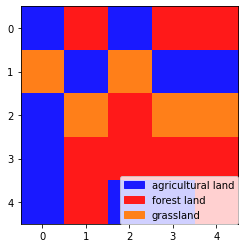

In [ ]:
##arrayLucc is the array of land use types
np.random.seed(0)
arrayLucc = np.random.randint(1,4,(5,5))
## first you need to define your color map and value name as a dic
t = 1 ## alpha value
cmap = {1:[0.1,0.1,1.0,t],2:[1.0,0.1,0.1,t],3:[1.0,0.5,0.1,t]}
labels = {1:'agricultural land',2:'forest land',3:'grassland'}
arrayShow = np.array([[cmap[i] for i in j] for j in arrayLucc])    
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.imshow(arrayShow)
plt.legend(handles=patches, loc=4, borderaxespad=0.)
plt.show()

In [ ]:
arrayShow.shape

(5, 5, 4)

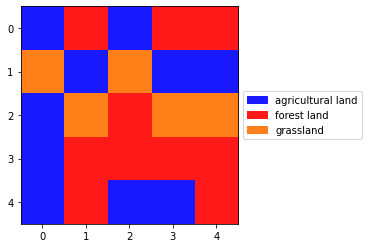

In [ ]:
##arrayLucc is the array of land use types
np.random.seed(0)
arrayLucc = np.random.randint(1,4,(5,5))

t = 1 ## alpha value
## first you need to define your color map and value name as a dic
cmap = {1:[0.1,0.1,1.0,t],2:[1.0,0.1,0.1,t],3:[1.0,0.5,0.1,t]}

labels = {1:'agricultural land',2:'forest land',3:'grassland'}

arr = np.expand_dims(arrayLucc, axis=-1)
arr = np.concatenate([arr, arr, arr, np.ones(shape=arr.shape)], axis=2)

arrayShow = np.zeros(shape=arr.shape)

for color in cmap.keys():
    clr = (color, color, color, 1)
    arrayShow = np.where(arr==clr, cmap[color], arrayShow)

## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.imshow(arrayShow)
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
arr

array([[[1., 1., 1., 1.],
        [2., 2., 2., 1.],
        [1., 1., 1., 1.],
        [2., 2., 2., 1.],
        [2., 2., 2., 1.]],

       [[3., 3., 3., 1.],
        [1., 1., 1., 1.],
        [3., 3., 3., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [3., 3., 3., 1.],
        [2., 2., 2., 1.],
        [3., 3., 3., 1.],
        [3., 3., 3., 1.]],

       [[1., 1., 1., 1.],
        [2., 2., 2., 1.],
        [2., 2., 2., 1.],
        [2., 2., 2., 1.],
        [2., 2., 2., 1.]],

       [[1., 1., 1., 1.],
        [2., 2., 2., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [2., 2., 2., 1.]]])

{1: 'agricultural land', 2: 'forest land', 3: 'grassland'}

In [ ]:
cmap

{1: [0.1, 0.1, 1.0, 1], 2: [1.0, 0.1, 0.1, 1], 3: [1.0, 0.5, 0.1, 1]}

In [ ]:
arrayLucc==color

array([[False,  True, False,  True,  True],
       [False,  True, False,  True,  True],
       [False, False, False, False, False],
       [ True,  True,  True, False,  True],
       [False, False,  True,  True, False]])

In [ ]:
arr = np.expand_dims(arrayLucc, axis=-1)
arr = np.concatenate([arr, arr, arr, np.ones(shape=arr.shape)], axis=2)

arrayShow = np.ones(shape=arr.shape)

for color in cmap.keys():
    arrayShow = np.where(arr==color, cmap[color], arrayLucc)




ValueError: operands could not be broadcast together with shapes (5,5,4) (4,) (5,5) 